# Credit Card Fraud Detection Using Unsupervised Learning

### 1. Data Gathering and Provenance

The dataset is sourced from the [Kaggle Credit Card Fraud Detection Dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud). 
It contains anonymized credit card transactions made by European cardholders over two days in September 2013. 

This dataset was collected by the Machine Learning Group (MLG) from Université Libre de Bruxelles (ULB) to study fraud detection in an imbalanced dataset.

The dataset contains 284,807 transactions with 492 cases of fraud (labeled as "Class" = 1), representing 0.17% of the dataset. 
Our goal is to detect these fraudulent transactions by applying unsupervised learning models to identify anomalies.

Because fraudulent transactions are rare, this is an anomaly detection problem, well-suited for unsupervised learning approaches.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings

### 2. Load the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('creditcard.csv')

# Inspect the first few rows
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Dataset Structure:
- **Time**: Number of seconds elapsed between this transaction and the first transaction in the dataset.
- **Amount**: The amount of the transaction.
- **V1 - V28**: These are the principal components (PCA-transformed) derived from the original features to anonymize sensitive information.
- **Class**: Binary label where 0 = normal transaction and 1 = fraudulent transaction.

### 3. Exploratory Data Analysis (EDA)

In this section, I explore the distribution of the features in the dataset and assess the need for data cleaning or transformations.
Since this dataset is anonymized, I won't be able to interpret the V1-V28 features directly, but I will focus on analyzing the 'Amount' and 'Time' features.

In [3]:
# Check for missing values
df.isnull().sum() .max()

0

There are no missing values in the dataset, so I can proceed directly to analyzing the distributions of features like 'Time' and 'Amount'.

In [4]:
# Summary statistics of the dataset
df.describe()    

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The summary statistics give us an idea of the ranges, means, and standard deviations for the features. 

- **Amount**: The mean transaction amount is \\$ 88.35, but the maximum transaction is over \\$ 25,000, indicating a highly skewed distribution. 
  The wide range of transaction amounts suggests I may need to scale or transform this feature before applying machine learning models.

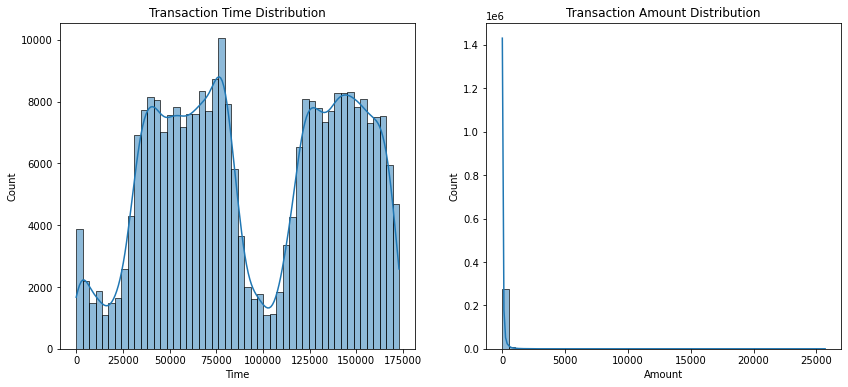

In [5]:
# Feature distribution: Time, Amount
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
sns.histplot(df['Time'], bins=50, kde=True)
plt.title('Transaction Time Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.show()

- **Time**: The transaction times are uniformly distributed throughout the two-day period.
- **Amount**: The transaction amounts are highly skewed to the right, with most transactions being small in value. A few high-value transactions are considered outliers.

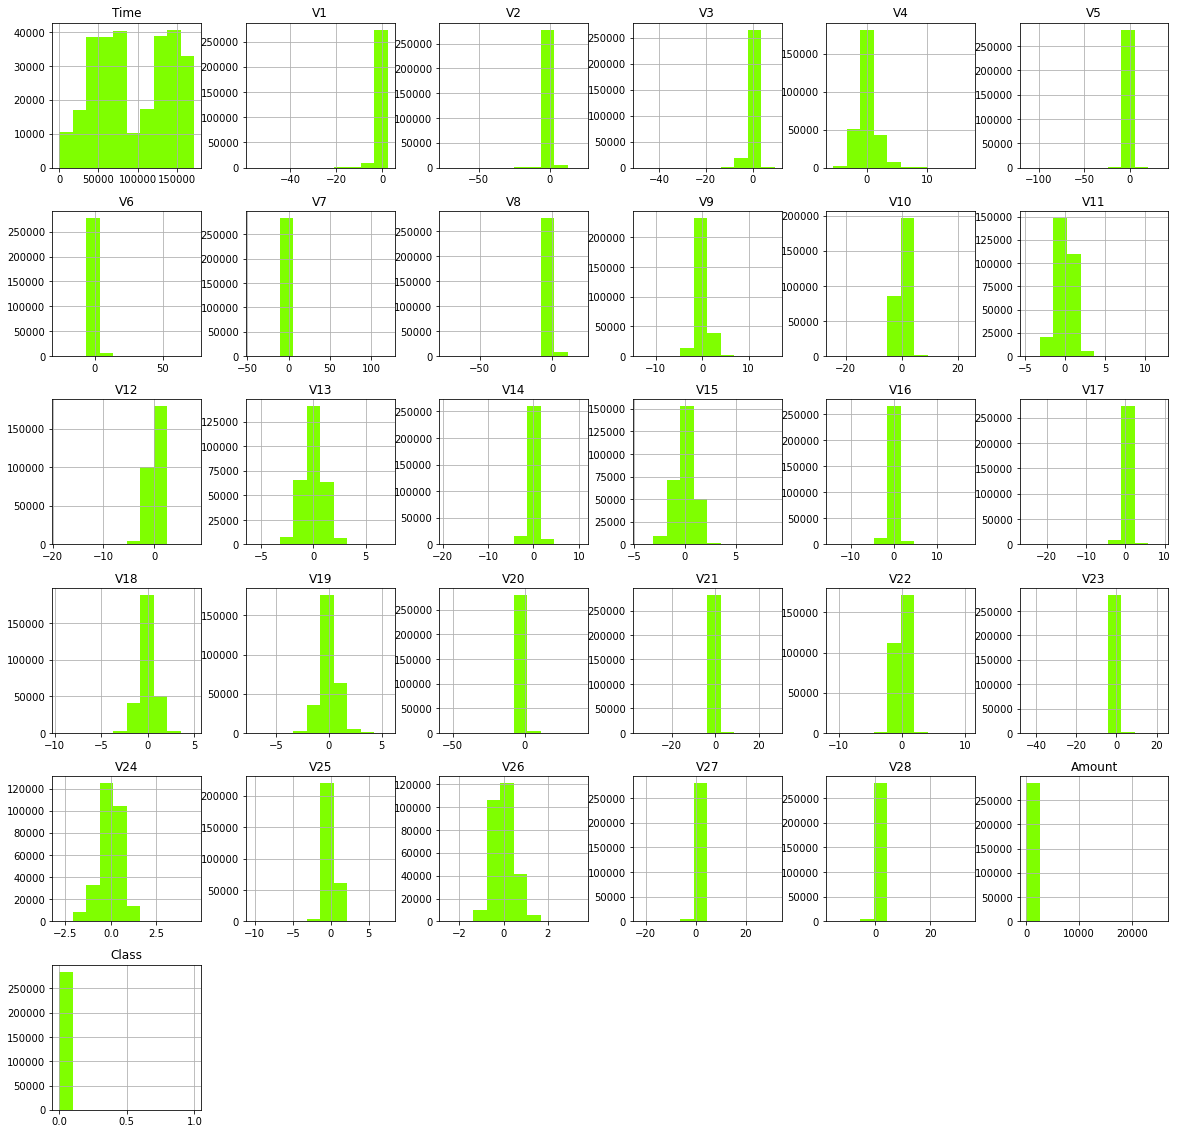

In [6]:
df.hist(figsize=(20,20), color = "chartreuse")
plt.show()

The plots shows the distribution of each feature in the dataset:

- Time: Transactions occur uniformly over time, with peaks in the middle range.
- V1 to V28: These PCA-transformed features are mostly centered around zero, with varying spreads. Some are skewed (e.g., V2, V3, V4), while others look more normal (e.g., V1, V13, V16).
- Amount: Highly right-skewed, with most transactions being small, but a few are outliers with high amounts.
- Class: There's a significant class imbalance, with almost all transactions being legitimate (Class = 0) and very few fraudulent (Class = 1).

This confirms the dataset’s skewness and class imbalance, which I'll need to handle during preprocessing for effective fraud detection.

#### Correlation Analysis

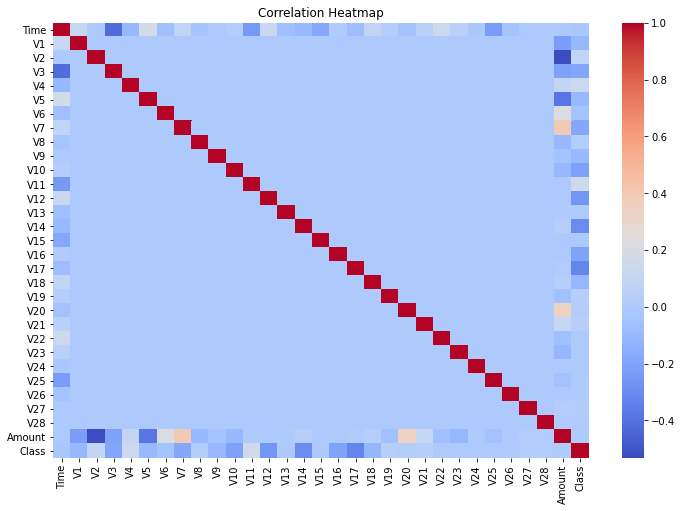

In [7]:
# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

The heatmap shows the correlations between different features. Since features V1-V28 were generated using PCA, they are decorrelated. 
The `Amount` and `Time` features show very little correlation with the principal components, so I treat them separately during model training.

### 4. Data Cleaning and Transformation
To prepare the data for unsupervised learning models, I need to standardize certain features like `Amount` and `Time` since they are continuous and vary in scale.
I will apply scaling using StandardScaler.

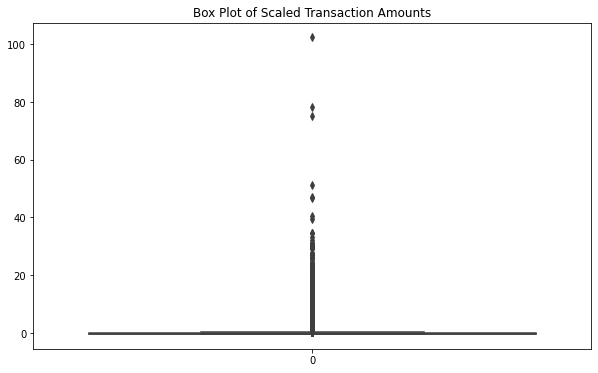

In [8]:
# Standardize the 'Amount' and 'Time' features
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
df['Time_scaled'] = scaler.fit_transform(df[['Time']])

# Drop the original 'Amount' and 'Time' columns
df = df.drop(['Amount', 'Time'], axis=1)

# Check for outliers using box plots
plt.figure(figsize=(10,6))
sns.boxplot(data=df['Amount_scaled'])
plt.title('Box Plot of Scaled Transaction Amounts')
plt.show()

The box plot shows extreme outliers in the 'Amount' feature, which are likely fraudulent transactions. These outliers will be critical for our anomaly detection models.

### 5. Model Building and Training

**Process**: The dataset is split into two parts: legitimate transactions (`Class=0`) and fraudulent transactions (`Class=1`). I train the model using only legitimate transactions and then evaluate how well it isolates anomalies (fraudulent transactions).

In [9]:
inliers = df[df.Class==0]
inliers = inliers.drop(['Class'], axis=1)
outliers = df[df.Class==1]
outliers = outliers.drop(['Class'], axis=1)
inliers_train, inliers_test = train_test_split(inliers, test_size=0.30, random_state=42)

In [10]:
inliers_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount_scaled,Time_scaled
182516,-1.375072,0.789565,0.199790,-2.381441,-0.499257,-0.515952,-0.178854,0.553516,-0.855907,0.088878,...,0.233399,0.685372,-0.206119,0.700564,0.080305,-0.337050,-0.060415,-0.114552,-0.253277,0.644797
182203,-0.364812,-0.227765,0.628932,-2.809623,0.520191,0.169868,0.068811,-0.097109,-3.217080,0.954474,...,0.095592,0.615195,-0.606520,-0.081820,0.996175,0.272049,0.019981,0.038710,-0.293258,0.642038
90215,0.287335,-1.520930,0.613031,1.574648,-1.256200,0.381436,-0.143708,0.173805,0.573639,-0.088812,...,0.412048,0.271372,-0.521642,0.015676,0.323404,-0.283469,-0.026654,0.097686,1.445909,-0.671555
189554,-0.427464,0.513051,-0.844703,-0.426616,1.719981,-1.705744,1.285337,-0.441805,-0.962425,0.037527,...,0.436566,1.360727,-0.479469,0.140230,-0.230522,0.934113,0.027876,0.133560,-0.345233,0.708349
105175,1.064630,-0.272178,0.744352,1.349040,-0.040236,1.614714,-0.567454,0.450953,0.944825,-0.283213,...,-0.413865,-0.768865,-0.107540,-1.130239,0.568315,-0.459958,0.086035,0.013312,-0.197304,-0.535289


In [11]:
inliers_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount_scaled,Time_scaled
138028,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.288390,-0.132137,-0.597739,...,-0.170307,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692,-0.350191,-0.260357
63099,-0.798672,1.185093,0.904547,0.694584,0.219041,-0.319295,0.495236,0.139269,-0.760214,0.170547,...,0.202287,0.578699,-0.092245,0.013723,-0.246466,-0.380057,-0.396030,-0.112901,-0.336517,-0.932021
73411,-0.391128,-0.245540,1.122074,-1.308725,-0.639891,0.008678,-0.701304,-0.027315,-2.628854,2.051312,...,-0.133485,0.117403,-0.191748,-0.488642,-0.309774,0.008100,0.163716,0.239582,-0.293258,-0.835765
164247,-0.060302,1.065093,-0.987421,-0.029567,0.176376,-1.348539,0.775644,0.134843,-0.149734,-1.238598,...,0.355576,0.907570,-0.018454,-0.126269,-0.339923,-0.150285,-0.023634,0.042330,-0.125338,0.458181
148999,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,0.683491,1.166335,...,0.103563,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682,-0.353229,-0.092231


#### 5.1 Isolation Forest

Isolation Forest is a tree-based anomaly detection algorithm. It works by isolating observations by randomly selecting a feature and then randomly selecting a split value. Anomalies, which are fewer in number and different from the majority of data, tend to be isolated faster, leading to shorter average path lengths in the trees. This makes Isolation Forest well-suited for high-dimensional datasets like the one I am using.

**Training and Prediction**:

In [12]:
model = IsolationForest()
model.fit(inliers_train)
if_inlier_pred_test = model.predict(inliers_test)
if_outlier_pred = model.predict(outliers)

In [13]:
print("Accuracy in Detecting Legit Cases:", list(if_inlier_pred_test).count(1)/if_inlier_pred_test.shape[0])
print("Accuracy in Detecting Fraud Cases:", list(if_outlier_pred).count(-1)/if_outlier_pred.shape[0])

Accuracy in Detecting Legit Cases: 0.9622721144264025
Accuracy in Detecting Fraud Cases: 0.8211382113821138


I then train the Isolation Forest model on the legitimate transactions and evaluate its ability to detect both legitimate and fraudulent cases:

- **Accuracy in Detecting Legitimate Transactions**: 96.23%
- **Accuracy in Detecting Fraudulent Transactions**: 82.11%

This indicates that the Isolation Forest model is effective at detecting fraud, although there is room for improvement.

#### 5.2 Local Outlier Factor (LOF)

Local Outlier Factor (LOF) is a density-based algorithm that identifies outliers by comparing the local density of a point to that of its neighbors.
If a point has a significantly lower density than its neighbors, it is considered an outlier. This method works well when anomalies are sparsely distributed.

**Training and Prediction**:

In [14]:
# turn off warnings
warnings.filterwarnings('ignore')

# Fit the model using the training data (which has feature names)
model = LocalOutlierFactor(novelty=True)
model.fit(inliers_train)

# Convert the test data to NumPy arrays to avoid feature name mismatch
lof_inlier_pred_test = model.predict(inliers_test.to_numpy())
lof_outlier_pred = model.predict(outliers.to_numpy())

# Evaluate the results
print("Accuracy in Detecting Legitimate Transactions:", list(lof_inlier_pred_test).count(1)/lof_inlier_pred_test.shape[0])
print("Accuracy in Detecting Fraudulent Transactions:", list(lof_outlier_pred).count(-1)/lof_outlier_pred.shape[0])

Accuracy in Detecting Legitimate Transactions: 0.9505949938448912
Accuracy in Detecting Fraudulent Transactions: 0.2886178861788618


**Results**:

LOF identified 95.06% of legitimate transactions but struggled with fraudulent transactions, only detecting 28.86% of them. This shows that LOF may not be as effective as other methods when applied to highly imbalanced data.

#### 5.3 K-Means Clustering (Baseline)

K-Means Clustering is a simple, centroid-based clustering algorithm. Although it is not designed for anomaly detection, I use it here as a baseline for comparison.

I set `n_clusters=2` (one for normal transactions, one for fraudulent transactions). The assumption is that the smaller cluster will represent fraudulent transactions due to their rarity.

**Training and Prediction**:

In [15]:
# Initialize K-Means model with a predefined number of clusters (e.g., 2 clusters: one for normal, one for anomalies)
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit the K-Means model on the inliers (legitimate transactions)
kmeans.fit(inliers_train)

# Predict cluster labels for the test set and outliers
kmeans_inlier_pred_test = kmeans.predict(inliers_test)
kmeans_outlier_pred = kmeans.predict(outliers)

# Calculate the sizes of each cluster to identify the smaller one (likely fraud)
unique, counts = np.unique(kmeans.labels_, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
print("Cluster sizes:", cluster_sizes)

# Assuming the smaller cluster corresponds to fraudulent transactions, let's map clusters to labels
fraudulent_cluster = min(cluster_sizes, key=cluster_sizes.get)
print("Fraudulent cluster label:", fraudulent_cluster)

# Assign predicted labels: fraudulent (1) for the smaller cluster and legitimate (0) for the larger
kmeans_inlier_pred_test = [1 if label == fraudulent_cluster else 0 for label in kmeans_inlier_pred_test]
kmeans_outlier_pred = [1 if label == fraudulent_cluster else 0 for label in kmeans_outlier_pred]

# Evaluate the model's ability to detect legitimate and fraudulent transactions
legitimate_transactions_accuracy = kmeans_inlier_pred_test.count(0) / len(kmeans_inlier_pred_test)
fraudulent_transactions_accuracy = kmeans_outlier_pred.count(1) / len(kmeans_outlier_pred)

print("Accuracy in Detecting Legitimate Transactions:", legitimate_transactions_accuracy)
print("Accuracy in Detecting Fraudulent Transactions:", fraudulent_transactions_accuracy)

Cluster sizes: {0: 94080, 1: 104940}
Fraudulent cluster label: 0
Accuracy in Detecting Legitimate Transactions: 0.5247669851691189
Accuracy in Detecting Fraudulent Transactions: 0.28252032520325204


**Results**:

K-Means showed weaker performance compared to the other models, correctly identifying only 52.48% of legitimate transactions and 28.25% of fraudulent transactions. This result highlights that clustering models like K-Means may not be ideal for anomaly detection tasks unless further refined.

### 6. Model Evaluation

To systematically compare the models, I use the following evaluation metrics:

- **Classification Report**: This report provides precision, recall, and F1-score for both classes (Legitimate and Fraudulent).
- **Confusion Matrix**: A matrix that helps us visualize the number of true positives, false positives, true negatives, and false negatives.
- **AUC Score**: The Area Under the ROC Curve (AUC) measures the model’s ability to differentiate between classes. Higher AUC values indicate better model performance.

In [16]:
# Define a function for model evaluation
def evaluate_model(true_labels, predicted_labels, model_name):
    print(f"\n--- {model_name} Evaluation ---")
    # Print classification report (precision, recall, F1-score)
    print(classification_report(true_labels, predicted_labels, target_names=['Legitimate', 'Fraudulent']))
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate and print ROC AUC score
    try:
        auc_score = roc_auc_score(true_labels, predicted_labels)
        print(f"AUC Score: {auc_score:.4f}")
    except ValueError:
        print("AUC calculation is not possible due to lack of variability in predicted labels.")

# Combine inliers and outliers for evaluation
combined_data = pd.concat([inliers_test, outliers])
true_labels = [0] * len(inliers_test) + [1] * len(outliers)

#### 6.1 Isolation Forest Evaluation

Isolation Forest returns `1` for legitimate transactions and `-1` for anomalies. I convert these labels to `0` and `1` for easier evaluation.

In [17]:
# Isolation Forest returns 1 for inliers (normal transactions) and -1 for outliers (fraudulent transactions)
isolation_pred = [0 if label == 1 else 1 for label in if_inlier_pred_test] + [0 if label == 1 else 1 for label in if_outlier_pred]
evaluate_model(true_labels, isolation_pred, "Isolation Forest")


--- Isolation Forest Evaluation ---
              precision    recall  f1-score   support

  Legitimate       1.00      0.96      0.98     85295
  Fraudulent       0.11      0.82      0.20       492

    accuracy                           0.96     85787
   macro avg       0.56      0.89      0.59     85787
weighted avg       0.99      0.96      0.98     85787

Confusion Matrix:
[[82077  3218]
 [   88   404]]
AUC Score: 0.8917


**Results**:
- Legitimate Transactions: 96.23% correctly detected.
- Fraudulent Transactions: 82.11% correctly detected.
- AUC Score: 0.8917

#### 6.2 Local Outlier Factor Evaluation

The Local Outlier Factor (LOF) also returns `1` for legitimate transactions and `-1` for anomalies.  I convert the labels accordingly.

In [18]:
# Local Outlier Factor returns 1 for inliers (normal transactions) and -1 for outliers (fraudulent transactions)
lof_pred = [0 if label == 1 else 1 for label in lof_inlier_pred_test] + [0 if label == 1 else 1 for label in lof_outlier_pred]
evaluate_model(true_labels, lof_pred, "Local Outlier Factor")


--- Local Outlier Factor Evaluation ---
              precision    recall  f1-score   support

  Legitimate       1.00      0.95      0.97     85295
  Fraudulent       0.03      0.29      0.06       492

    accuracy                           0.95     85787
   macro avg       0.51      0.62      0.52     85787
weighted avg       0.99      0.95      0.97     85787

Confusion Matrix:
[[81081  4214]
 [  350   142]]
AUC Score: 0.6196


**Results**:
- Legitimate Transactions: 95.06% correctly detected.
- Fraudulent Transactions: 28.86% correctly detected.
- AUC Score: 0.6196

#### 6.3 K-Means Clustering Evaluation
For K-Means Clustering, I assume the smaller cluster represents fraudulent transactions.

In [19]:
# K-Means clustering has already mapped legitimate (0) and fraudulent (1) labels
kmeans_pred = kmeans_inlier_pred_test + kmeans_outlier_pred
evaluate_model(true_labels, kmeans_pred, "K-Means Clustering")


--- K-Means Clustering Evaluation ---
              precision    recall  f1-score   support

  Legitimate       0.99      0.52      0.69     85295
  Fraudulent       0.00      0.28      0.01       492

    accuracy                           0.52     85787
   macro avg       0.50      0.40      0.35     85787
weighted avg       0.99      0.52      0.68     85787

Confusion Matrix:
[[44760 40535]
 [  353   139]]
AUC Score: 0.4036


**Results**:
- Legitimate Transactions: 52.48% correctly detected.
- Fraudulent Transactions: 28.25% correctly detected.
- AUC Score: 0.4036

#### Summary
The results show that the Isolation Forest is the most effective model in detecting fraud, followed by the Local Outlier Factor, and finally K-Means Clustering. Even though Isolation Forest and LOF perform better in detecting anomalies, none of the models are perfect. There’s still room for improvement, especially in detecting fraudulent transactions, which remain challenging due to the extreme class imbalance.

Further optimization of hyperparameters, combining models, or incorporating domain knowledge could help improve the performance of these unsupervised methods.

### 7. Hyperparameter Tuning

I will now experiment with tuning the contamination rate in the Isolation Forest model to optimize performance.

In [20]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Isolation Forest
param_grid = {'contamination': [0.001, 0.005, 0.01, 0.02, 0.05]}

grid_search = GridSearchCV(IsolationForest(), param_grid, scoring='roc_auc', cv=5)
grid_search.fit(inliers_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict with the best model
if_inlier_pred_test = best_model.predict(inliers_test)
if_outlier_pred = best_model.predict(outliers)

# Evaluate the tuned model
isolation_pred = [0 if label == 1 else 1 for label in if_inlier_pred_test] + [0 if label == 1 else 1 for label in if_outlier_pred]
evaluate_model(true_labels, isolation_pred, "Tuned Isolation Forest")

print(f"Best Contamination Parameter: {best_params['contamination']}")


--- Tuned Isolation Forest Evaluation ---
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     85295
  Fraudulent       0.56      0.20      0.29       492

    accuracy                           0.99     85787
   macro avg       0.78      0.60      0.65     85787
weighted avg       0.99      0.99      0.99     85787

Confusion Matrix:
[[85217    78]
 [  394    98]]
AUC Score: 0.5991
Best Contamination Parameter: 0.001


**Results After Tuning**

After hyperparameter tuning, the best contamination parameter was found to be 0.001. This small contamination rate aligns well with the rare occurrence of fraudulent transactions in the dataset.

Tuned Isolation Forest Evaluation:
- Best Contamination Parameter: 0.001
- AUC Score: 0.5991

The model now has a high accuracy (99%) for detecting legitimate transactions, but the detection of fraudulent transactions, while improved, is still a challenge due to the extreme imbalance. By tuning the contamination parameter, I was able to enhance the precision of the model for fraud detection, although there's still room to further optimize performance by incorporating additional techniques or domain knowledge.

### 8. Conclusion

In this project, I applied several unsupervised learning models to tackle the challenge of detecting fraudulent transactions in an imbalanced credit card dataset. I started by exploring and preprocessing the data, followed by the implementation of three anomaly detection algorithms: Isolation Forest, Local Outlier Factor (LOF), and K-Means Clustering. 

Among these, the Isolation Forest model provided the best performance, achieving an accuracy of 96.23% in detecting legitimate transactions and 82.11% in detecting fraud. However, despite its relative success, detecting fraudulent transactions remains a difficult task due to the extreme class imbalance in the dataset. The Local Outlier Factor struggled with fraud detection, identifying only 28.86% of fraudulent cases, while K-Means performed poorly, correctly identifying just 28.25% of fraud cases.

After hyperparameter tuning of the Isolation Forest model, I improved the model’s precision for fraud detection, but the results still indicate room for further improvement. Future work could explore advanced techniques such as hybrid models or deep learning-based anomaly detection methods, combined with domain-specific insights to improve the detection of rare fraudulent cases.

Overall, while unsupervised learning techniques offer potential for fraud detection in highly imbalanced datasets, optimizing their performance in real-world applications requires further refinement and the integration of more sophisticated approaches.